In [1]:
#!git clone https://github.com/William-Chittavong/torchscale.git

In [2]:
# LEFT OFF: hook has wrong path for imports. change them

In [3]:
!pip uninstall torchscale -y

Found existing installation: torchscale 0.2.0
Uninstalling torchscale-0.2.0:
  Successfully uninstalled torchscale-0.2.0


In [4]:
!pip install git+https://github.com/William-Chittavong/torchscale.git

  Cloning https://github.com/William-Chittavong/torchscale.git to /tmp/pip-req-build-ka8gr5k_
  Running command git clone --filter=blob:none --quiet https://github.com/William-Chittavong/torchscale.git /tmp/pip-req-build-ka8gr5k_
  Resolved https://github.com/William-Chittavong/torchscale.git to commit 7c1dc4107af7c7c37f997b96465255d7bf111e71
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for torchscale, since package 'wheel' is not installed.
  Running setup.py install for torchscale ... done


In [5]:
import math
import torch
import torch.nn as nn

from torchscale.model.BEiT3 import create_beit3_retrieval_model
from torchscale.component.hook import HookManager


from torchvision import transforms

from torchscale.component.beit3_utils import load_model_and_may_interpolate

from torchscale.component.transform import visualization_preprocess, image_grid , image_transform
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader
import heapq
import tqdm

from transformers import XLMRobertaTokenizer
from PIL import Image
from torchscale.component.prs_hook import hook_prs_logger
from einops import rearrange

device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'

In [6]:

hook = HookManager()
model_size = "base"
img_size = 224

retrieve_model = create_beit3_retrieval_model(model_size='base',hook_manager= hook, img_size=224)

In [7]:




tokenizer = XLMRobertaTokenizer("/home/william/Documents/GitHub/torchscale/beit3.spm")

image_path = "/home/william/project/images/catdog.png"
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the size expected by the model
    transforms.ToTensor(),          # Convert to tensor
])

img_tensor = transform(image).unsqueeze(0).requires_grad_(True)
img_tensor = img_tensor.to(device)

checkpoint_path = "https://github.com/addf400/files/releases/download/beit3/beit3_base_patch16_224.pth"

image_text_contrastive_checkpoint = "https://github.com/addf400/files/releases/download/beit3/beit3_base_itc_patch16_224.pth"


# Load the checkpoint into vqa_fixed
#load_model_and_may_interpolate(checkpoint_path, vqa_model, model_key='model', model_prefix='')

load_model_and_may_interpolate(image_text_contrastive_checkpoint, retrieve_model, model_key='model', model_prefix='')



retrieve_model.to(device)
retrieve_model.eval()


Load ckpt from https://github.com/addf400/files/releases/download/beit3/beit3_base_itc_patch16_224.pth
Load state_dict by model_key = model


BEiT3ForRetrieval(
  (beit3): BEiT3(
    (text_embed): TextEmbedding(64010, 768)
    (vision_embed): VisionEmbedding(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): Encoder(
      (dropout_module): Dropout(p=0.0, inplace=False)
      (embed_positions): MutliwayEmbedding(
        (A): PositionalEmbedding(199, 768)
        (B): PositionalEmbedding(1024, 768)
      )
      (layers): ModuleList(
        (0-11): 12 x EncoderLayer(
          (self_attn): MultiheadAttention(
            (k_proj): MultiwayNetwork(
              (A): Linear(in_features=768, out_features=768, bias=True)
              (B): Linear(in_features=768, out_features=768, bias=True)
            )
            (v_proj): MultiwayNetwork(
              (A): Linear(in_features=768, out_features=768, bias=True)
              (B): Linear(in_features=768, out_features=768, bias=True)
            )
            (q_proj): MultiwayNetwork(
              (A): Linear(in_features=768, out_featu

In [8]:
lines = ['An image of a dog', 'An image of a cat']
texts = tokenizer(lines)  # tokenize

# lines = ['An image of a dog']
# texts = tokenizer(lines)  # tokenize
input_ids = torch.tensor(texts["input_ids"]).to(device)
attention_mask = torch.tensor(texts["attention_mask"]).to(device)

with torch.no_grad():
    _,text_rep = retrieve_model(text_description = input_ids  , padding_mask = attention_mask, only_infer = True)
 

In [9]:

encoder_embed_dim = 768
prs = hook_prs_logger(retrieve_model,encoder_embed_dim  ,device)


In [10]:
retrieve_model

BEiT3ForRetrieval(
  (beit3): BEiT3(
    (text_embed): TextEmbedding(64010, 768)
    (vision_embed): VisionEmbedding(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): Encoder(
      (dropout_module): Dropout(p=0.0, inplace=False)
      (embed_positions): MutliwayEmbedding(
        (A): PositionalEmbedding(199, 768)
        (B): PositionalEmbedding(1024, 768)
      )
      (layers): ModuleList(
        (0-11): 12 x EncoderLayer(
          (self_attn): MultiheadAttention(
            (k_proj): MultiwayNetwork(
              (A): Linear(in_features=768, out_features=768, bias=True)
              (B): Linear(in_features=768, out_features=768, bias=True)
            )
            (v_proj): MultiwayNetwork(
              (A): Linear(in_features=768, out_features=768, bias=True)
              (B): Linear(in_features=768, out_features=768, bias=True)
            )
            (q_proj): MultiwayNetwork(
              (A): Linear(in_features=768, out_featu

In [11]:
retrieve_model.beit3.encoder.layers[0].self_attn.out_proj.B.bias

Parameter containing:
tensor([-2.4597e-02,  5.6763e-02, -2.6505e-02, -7.1472e-02,  6.0844e-03,
         1.7090e-02, -7.3303e-02,  1.8677e-02, -5.8060e-03,  2.5436e-02,
        -2.6035e-03, -2.6596e-02,  4.7729e-02, -1.8097e-02, -3.7537e-02,
        -4.0627e-03, -5.1956e-03,  1.0168e-01, -1.1581e-02, -9.2459e-04,
        -2.1973e-02, -2.5330e-02, -1.8115e-01, -3.9429e-02, -9.8515e-04,
        -3.5248e-02, -1.0541e-01,  2.1072e-02, -8.6746e-03, -2.0325e-02,
        -1.8677e-02, -1.2201e-01,  2.0605e-01, -4.5105e-02,  1.1185e-02,
        -6.6589e-02, -5.2223e-03, -4.7424e-02,  1.2980e-03,  1.6724e-02,
        -3.0151e-02, -6.7993e-02, -6.7017e-02, -3.9551e-02, -7.0419e-03,
         6.5063e-02, -1.0773e-01, -2.4673e-02, -1.6098e-02, -1.6571e-02,
        -7.8125e-03, -7.5378e-03,  9.8511e-02, -2.8152e-02, -8.3740e-02,
        -9.1476e-03,  7.9346e-02, -2.7054e-02,  2.2926e-03, -3.5065e-02,
         1.9446e-01, -3.1376e-04, -5.3177e-03, -1.5442e-02, -3.5057e-03,
        -1.4453e-01, -3.9177e

In [12]:
# WHY 24 layers 

# and have to fix the permute. 

# was there something wrong with the use of the text description?

# i think i saw use of the model separatedly. 

In [13]:
prs.reinit()
with torch.no_grad():
    img_rep , _ = retrieve_model(image=img_tensor, normalize = False ,only_infer = True)
    attentions = prs.finalize(img_rep)


In [14]:
# prs.reinit()
# with torch.no_grad():
#     img_rep, text_rep = retrieve_model(image=img_tensor,text_description = input_ids  , padding_mask = attention_mask, only_infer = True)
    
#     attentions = prs.finalize(img_rep)


In [15]:
norm = img_rep.norm(dim=-1)
norm

tensor([39.7057], device='cuda:0')

In [16]:
# b n 1 (h d)
attentions.shape

torch.Size([1, 12, 768])

In [17]:

attentions = rearrange(attentions , "b l (h d) -> b l h d",h = 12)
attentions.shape

# b l n h d

torch.Size([1, 12, 12, 64])

In [18]:
## Define the head for which you want to search (e.g. "counting" head)

search_head = (11, 4) # (layer, head, , try also - (23, 8) for color head

query = attentions[0, search_head[0], search_head[1]]
query.shape

torch.Size([64])

In [19]:
scores = attentions[:, search_head[0], search_head[1]] @ query
scores


tensor([0.1438], device='cuda:0')

In [20]:
query.shape

torch.Size([64])

In [21]:
text_rep.shape

torch.Size([2, 768])

In [22]:
img_rep.shape

torch.Size([1, 768])

In [23]:

## Create the pool for the nn search
preprocess = image_transform(
        image.size,
        is_train=False,
    )

imagenet_path = "/home/william/imagenet"
batch_size = 8 # only needed for the nn search
ds_vis = ImageNet(root=imagenet_path, split="val", transform=visualization_preprocess) # For showing images
ds = ImageNet(root=imagenet_path, split="val", transform=preprocess) # For running the model
dataloader = DataLoader(
    ds, batch_size=batch_size, shuffle=False, num_workers=8
)

In [24]:

db = [(-float("inf"), None) for _ in range(15)]
for index, (images, _) in tqdm.tqdm(enumerate(dataloader)):
    images = images.to(device)
    with torch.no_grad():
        prs.reinit()
        img_rep , _ = retrieve_model(image=images,normalize = False  ,only_infer = True)
        current_attentions = prs.finalize(img_rep)  # attentions: [batch_size, layers, heads, repr_size]
        current_attentions = rearrange(current_attentions , "b l (h d) -> b l h d",h = 12)
        # print(current_attentions.shape,"current_attentions shape\n")
        # print(current_attentions[:, search_head[0], search_head[1]].shape,"layer head attn shape \n")
        scores = current_attentions[:, search_head[0], search_head[1]] @ query
        for i in range(min(batch_size, images.shape[0])):
            heapq.heappushpop(db, (scores[i], batch_size * index + i))
db = sorted(db, key=lambda x: -x[0])

6250it [05:12, 19.97it/s]


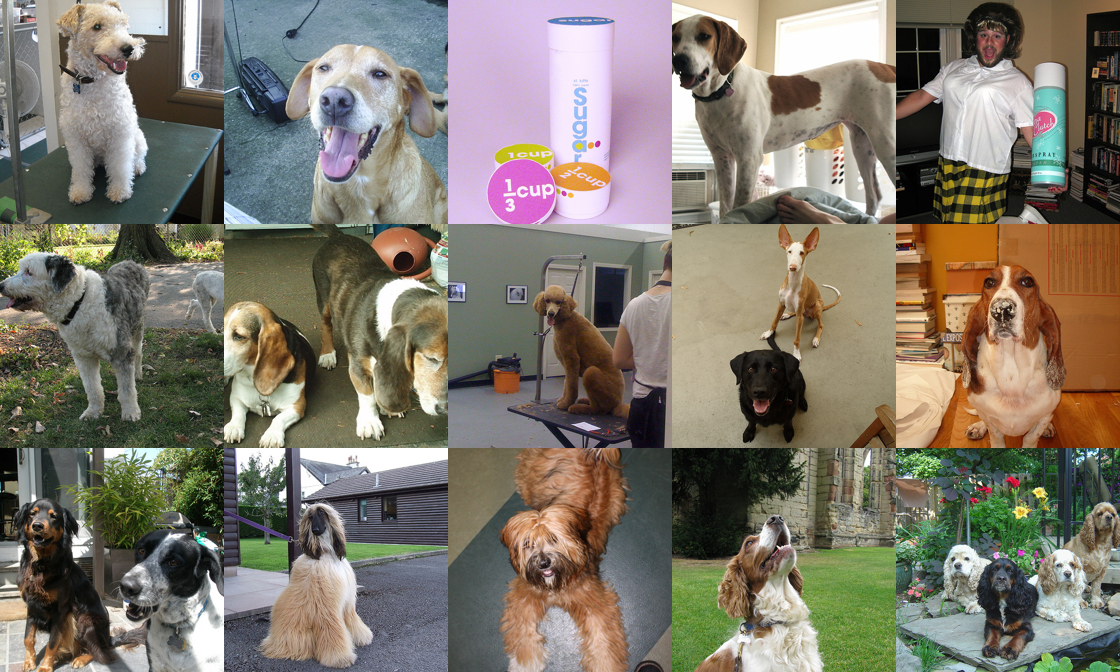

In [25]:
# Plot the top images in a grid:
images = []
for image_index in db:
    images.append(ds_vis[image_index[1]][0])
image_grid(images, 3, 5)

In [26]:
#torch.Size([1, 197, 1, 1, 12, 64010]) proj attentions
# b , n, _ , _ ,l, d

Visualize token decomposition